In [1]:
# General imports
import os
import sys
from scipy.stats import fisher_exact
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import subprocess

from sklearn.cluster import KMeans

from tqdm import tqdm

# Other imports
tqdm.pandas()

import json

from pprint import pprint

# Custom utils
sys.path.append("/home/weber/PycharmProjects/EXOTIC/src")
from utils.utils import load_config_file

# Figures imports
import matplotlib

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import random

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from statannot import add_stat_annotation
import matplotlib.font_manager as font_manager

plt.rcParams.update({"font.size": 30})


def heatmap_three(
    data_heatmap, data_barplot, data_profiles, concat_stats, path, keys, condition, filtering_used, up_lim=200, down_lim=0
):
    # print(data_heatmap)
    # print(data_heatmap.reset_index(drop=True).drop(["Condition"], axis=1).set_index(["Introns_nb"]).fillna(100))
    # exit()
    # print(data_barplot)
    # print(data_profiles)

    color_miso = "#C43032"
    color_siso = "#7B9FF9"
    palette = [color_miso, color_siso]

    modif_keys_intron_positions_columns = [e - keys[0] for e in keys[:10]]
    modif_keys_intron_positions_labels = [e - keys[0] + 1 for e in keys[:10]]

    f = plt.figure(constrained_layout=True, figsize=(40, 30))
    # f = plt.figure(constrained_layout=True, figsize=(40, 40))
    gs = f.add_gridspec(nrows=4, ncols=6, width_ratios=[1, 1, 1, 1, 0.5, 0.5], height_ratios=[5, 3, 1.5, 1.5])
    gs.update(hspace=0.05)

    ax_heatmap = f.add_subplot(gs[0, :-2])
    ax_barplot1 = f.add_subplot(gs[0, -2])
    ax_barplot2 = f.add_subplot(gs[0, -1])

    ax_cluster1 = f.add_subplot(gs[1, 0])
    ax_cluster2 = f.add_subplot(gs[1, 1])
    ax_cluster3 = f.add_subplot(gs[1, 2])
    ax_cluster4 = f.add_subplot(gs[1, 3])
    ax_legend = f.add_subplot(gs[1, 4])

    ax_h_barplot1 = f.add_subplot(gs[2, :-2])
    ax_h_barplot2 = f.add_subplot(gs[3, :-2])
    # print(data_heatmap)
    # print(data_heatmap.reset_index(drop=True).drop(["Condition"], axis=1).set_index(["Introns_nb"]).fillna(100))
    # exit()

    # data_heatmap = (
    # data_heatmap.reset_index(drop=True).drop(["Condition"], axis=1).set_index(["Introns_nb"]).fillna(0).T.reset_index(drop=True).T
    # )

    concat_stats = concat_stats.rename({"cluster_lite": "cluster_new", "Introns_nb_bins": "Introns_nb"}, axis=1)
    print(concat_stats)
    # data_heatmap = concat_stats.pivot(index="Introns_nb", columns="cluster_new", values="Fold")
    data_heatmap = data_heatmap

    stats_heatmap_false = (
        concat_stats[["cluster_new", "False_raw", "Introns_nb"]]
        .pivot(index=["Introns_nb"], columns=["cluster_new"], values=["False_raw"])
        .rename({"False_raw": "Count"}, axis=1)
        .T.reset_index(drop=True)
        .T.fillna(0)
        .astype(int)
        .astype(str)
    )

    stats_heatmap_true = (
        concat_stats[["cluster_new", "True_raw", "Introns_nb"]]
        .pivot(index=["Introns_nb"], columns=["cluster_new"], values=["True_raw"])
        .rename({"True_raw": "Count"}, axis=1)
        .T.reset_index(drop=True)
        .T.fillna(0)
        .astype(int)
        .astype(str)
    )

    data_heatmap_to_display = data_heatmap.round(0).applymap(lambda x: "+" + str(int(x)) if x > 0 else str(int(x)))
    stats_heatmap = stats_heatmap_false + " / " + stats_heatmap_true + " / " + data_heatmap_to_display.astype(str) + "%"
    print(stats_heatmap)
    # stats_heatmap = data_heatmap_to_display.astype(str) + "%"
    # print(stats_heatmap)

    sns.heatmap(
        data=data_heatmap,
        # center=int((up_lim - down_lim) / 2),
        center=0,
        vmin=down_lim,
        vmax=up_lim,
        annot=stats_heatmap.values.tolist(),
        fmt="",
        cmap="coolwarm",
        linecolor="grey",
        lw=0.01,
        ax=ax_heatmap,
        cbar_kws={"shrink": 0.4, "use_gridspec": False, "location": "left", "label": "% enrichment"},
    )
    ax_heatmap.set_xticklabels(["Cluster {}".format(i) for i in range(1, 5)])
    ax_heatmap.set_xlabel("")
    ax_heatmap.set_ylabel("Gene introns nb")
    ax_heatmap.set_title(
        "{} VS {} enrichment by cluster and by group for condition : {} | Filtering : {}".format(
            "True", "False", condition, filtering_used
        )
    )
    print(data_barplot.melt(id_vars=["Introns_nb"], value_vars=["True_raw", "False_raw"]))
    sns.barplot(
        data=data_barplot.melt(id_vars=["Introns_nb"], value_vars=["True_raw", "False_raw"]),
        y="Introns_nb",
        x="value",
        hue="variable",
        ax=ax_barplot1,
        palette=palette,
    )
    ax_barplot1.set_yticklabels([])
    ax_barplot1.set_ylabel("")
    ax_barplot1.set_xlabel("Genes count")
    ax_barplot1.yaxis.set_ticks_position("none")
    ax_barplot1.spines["right"].set_linewidth(0)
    ax_barplot1.spines["top"].set_linewidth(0)
    ax_barplot1.legend().remove()
    ax_barplot1.grid(axis="x")
    ax_barplot1.set_axisbelow(True)

    print(data_barplot.melt(id_vars=["Introns_nb"], value_vars=["True", "False"]))
    sns.barplot(
        data=data_barplot.melt(id_vars=["Introns_nb"], value_vars=["True", "False"]),
        y="Introns_nb",
        x="value",
        hue="variable",
        ax=ax_barplot2,
        palette=palette,
    )
    ax_barplot2.set_yticklabels([])
    ax_barplot2.set_ylabel("")
    ax_barplot2.set_xlabel("% compare\nto all genes")
    ax_barplot2.yaxis.set_ticks_position("none")
    ax_barplot2.spines["right"].set_linewidth(0)
    ax_barplot2.spines["top"].set_linewidth(0)
    ax_barplot2.grid(axis="x")
    ax_barplot2.legend().remove()
    ax_barplot2.set_axisbelow(True)

    print(data_profiles)

    max_ylim = 55
    # max_ylim = data_profiles.loc[data_profiles["cluster_new"] == 0].value.max()
    # print(data_profiles.loc[data_profiles["cluster_new"] == 0]["value"].max())
    sns.lineplot(data=data_profiles.loc[data_profiles["cluster_new"] == 0], x="variable", y="value", color="red", ax=ax_cluster1)

    # ax_cluster1.plot(modif_keys_intron_positions_labels, data_profiles[modif_keys_intron_positions_columns].loc[0].values, color="red")
    ax_cluster1.set_xlabel("Intron ordinal position")
    ax_cluster1.set_ylabel("")
    ax_cluster1.set_xticks([i for i in range(1, 11)])
    ax_cluster1.set_ylim(0, max_ylim)
    ax_cluster1.set_ylabel("Intron size\n(% gene body)")
    ax_cluster1.grid(axis="y")
    # ax.yaxis.get_minor_ticks()
    # ax_cluster1.set_xticklabels([str(i) for i in range(1,11)])

    # ax_cluster2.plot(modif_keys_intron_positions_labels, data_profiles[modif_keys_intron_positions_columns].loc[1].values, color="red")
    sns.lineplot(data=data_profiles.loc[data_profiles["cluster_new"] == 1], x="variable", y="value", color="green", ax=ax_cluster2)
    ax_cluster2.set_xlabel("Intron ordinal position")
    ax_cluster2.set_ylabel("")
    ax_cluster2.set_xticks([i for i in range(1, 11)])
    ax_cluster2.set_ylim(0, max_ylim)
    # ax_cluster2.set_yticks([])
    ax_cluster2.grid(axis="y")

    # ax_cluster3.plot(modif_keys_intron_positions_labels, data_profiles[modif_keys_intron_positions_columns].loc[2].values, color="red")
    sns.lineplot(data=data_profiles.loc[data_profiles["cluster_new"] == 2], x="variable", y="value", color="blue", ax=ax_cluster3)
    ax_cluster3.set_xlabel("Intron ordinal position")
    ax_cluster3.set_ylabel("")
    ax_cluster3.set_xticks([i for i in range(1, 11)])
    ax_cluster3.set_ylim(0, max_ylim)
    # ax_cluster3.set_yticks([])
    ax_cluster3.grid(axis="y")

    sns.lineplot(data=data_profiles.loc[data_profiles["cluster_new"] == 3], x="variable", y="value", color="black", ax=ax_cluster4)
    # ax_cluster4.plot(modif_keys_intron_positions_labels, data_profiles[modif_keys_intron_positions_columns].loc[3].values, color="red")
    ax_cluster4.set_xlabel("Intron ordinal position")
    ax_cluster4.set_ylabel("")
    ax_cluster4.set_xticks([i for i in range(1, 11)])
    ax_cluster4.set_ylim(0, max_ylim)
    ax_cluster4.set_ylabel("")
    ax_cluster4.grid(axis="y")
    # ax_cluster2.set_yticks([])

    import matplotlib.patches as mpatches

    miso_patch = mpatches.Patch(color=color_miso, label="Multi-isoforms")
    siso_patch = mpatches.Patch(color=color_siso, label="Single-isoform")
    ax_legend.spines["top"].set_linewidth(0)
    ax_legend.spines["bottom"].set_linewidth(0)
    ax_legend.spines["right"].set_linewidth(0)
    ax_legend.spines["left"].set_linewidth(0)
    ax_legend.yaxis.set_ticks_position("none")
    ax_legend.xaxis.set_ticks_position("none")
    ax_legend.legend(handles=[miso_patch, siso_patch], loc="upper center", fontsize="x-large")
    ax_legend.set_yticklabels([])
    ax_legend.set_xticklabels([])

    barplot_h_data = (
        concat_stats[["cluster_new", "False_raw", "True_raw"]]
        .groupby("cluster_new")
        .sum()
        .reset_index()
        .rename({"False_raw": "False", "True_raw": "True"}, axis=1)
        .melt(id_vars="cluster_new", value_vars=["True", "False"])
    )
    print(barplot_h_data)

    sns.barplot(data=barplot_h_data, x="cluster_new", y="value", hue="variable", ax=ax_h_barplot1, palette=palette)
    ax_h_barplot1.grid(axis="y", zorder=0)
    ax_h_barplot1.set_axisbelow(True)
    ax_h_barplot1.legend().remove()
    ax_h_barplot1.set_xticklabels(["Cluster {}".format(i) for i in range(1, 5)])
    ax_h_barplot1.set_xlabel("")
    ax_h_barplot1.set_ylabel("Genes count")
    ax_h_barplot1.spines["right"].set_linewidth(0)
    ax_h_barplot1.spines["top"].set_linewidth(0)

    def barplot_h_fct(r):
        r["ratio"] = 100 * (r["value"] / r["value"].sum())
        return r

    barplot_h_data_ratio = barplot_h_data.groupby("variable").apply(barplot_h_fct)
    print(barplot_h_data_ratio)

    sns.barplot(data=barplot_h_data_ratio, x="cluster_new", y="ratio", hue="variable", ax=ax_h_barplot2, palette=palette)
    ax_h_barplot2.grid(axis="y", zorder=0)
    ax_h_barplot2.set_axisbelow(True)
    ax_h_barplot2.legend().remove()
    ax_h_barplot2.set_xticklabels(["Cluster {}".format(i) for i in range(1, 5)])
    ax_h_barplot2.set_xlabel("")
    ax_h_barplot2.set_ylabel("% compare\nto all genes")
    ax_h_barplot2.spines["right"].set_linewidth(0)
    ax_h_barplot2.spines["top"].set_linewidth(0)

    f.savefig(path)
    # exit()


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [31]:
df = pd.DataFrame([
    {
        'Introns_nb' : '3',
        '0' : -7,
        '1' : -13,
        '2' : +26,
        '3' : -9,
    },
    {
        'Introns_nb' : '4',
        '0' : -7,
        '1' : +13,
        '2' : +26,
        '3' : -9,
    },
    {
        'Introns_nb' : '5',
        '0' : -7,
        '1' : -6,
        '2' : +26,
        '3' : -9,
    },
    {
        'Introns_nb' : '6',
        '0' : -7,
        '1' : +17,
        '2' : +26,
        '3' : -9,
    },    
    
])
df = df.melt(id_vars=['Introns_nb'], value_vars=['0','1','2','3'])
df

,Introns_nb,variable,value
0,3,0,-7
1,4,0,-7
2,5,0,-7
3,6,0,-7
4,3,1,-13
5,4,1,13
6,5,1,-6
7,6,1,17
8,3,2,26
9,4,2,26


,x,y,value
0,bore,bore,1.000000
1,stroke,bore,-0.055390
2,compression-ratio,bore,0.001263
3,horsepower,bore,0.566936
4,city-mpg,bore,-0.582027
5,price,bore,0.543155
6,bore,stroke,-0.055390
7,stroke,stroke,1.000000
8,compression-ratio,stroke,0.187871
9,horsepower,stroke,0.098267


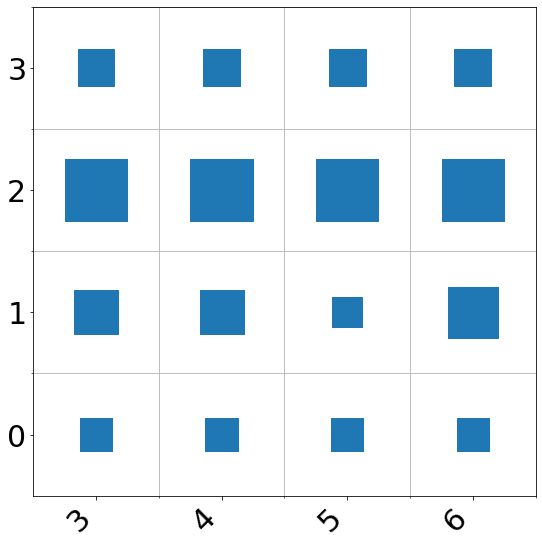

In [29]:
# Step 1 - Make a scatter plot with square markers, set column names as labels

def heatmap(x, y, size, color):
    fig, ax = plt.subplots(figsize=(9,9))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 150
    
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
    color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
        ind = int(val_position * (n_colors - 1)) # target index in the color palette
        return palette[ind]

    ax.scatter(
        x=x.map(x_to_num),
        y=y.map(y_to_num),
        s=size * size_scale,
#         c=color.apply(value_to_color), # Vector of square color values, mapped to color palette
        marker='s'
    )
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    
data = pd.read_csv('https://raw.githubusercontent.com/drazenz/heatmap/master/autos.clean.csv')
columns = ['bore', 'stroke', 'compression-ratio', 'horsepower', 'city-mpg', 'price'] 
corr = data[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']




heatmap(
    x=df['Introns_nb'],
    y=df['variable'],
    size=df['value'].abs(),
    color=df['value'],
)
corr

,x,y,value
0,bore,bore,1.000000
1,stroke,bore,-0.055390
2,compression-ratio,bore,0.001263
3,horsepower,bore,0.566936
4,city-mpg,bore,-0.582027
5,price,bore,0.543155
6,bore,stroke,-0.055390
7,stroke,stroke,1.000000
8,compression-ratio,stroke,0.187871
9,horsepower,stroke,0.098267


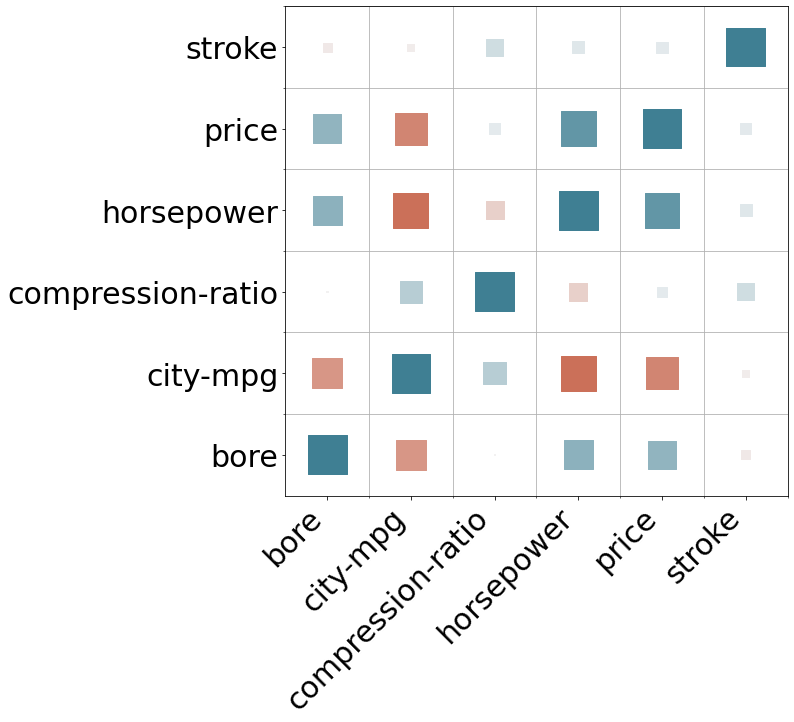

In [18]:
# Step 1 - Make a scatter plot with square markers, set column names as labels

def heatmap(x, y, size, color):
    fig, ax = plt.subplots(figsize=(9,9))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 1500
    
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
    color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
        ind = int(val_position * (n_colors - 1)) # target index in the color palette
        return palette[ind]

    ax.scatter(
        x=x.map(x_to_num),
        y=y.map(y_to_num),
        s=size * size_scale,
        c=color.apply(value_to_color), # Vector of square color values, mapped to color palette
        marker='s'
    )
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    
data = pd.read_csv('https://raw.githubusercontent.com/drazenz/heatmap/master/autos.clean.csv')
columns = ['bore', 'stroke', 'compression-ratio', 'horsepower', 'city-mpg', 'price'] 
corr = data[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']




heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color=corr['value'],
)
corr